This is [Kevin Systrom's code](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/)
for estimating $R_0$, but applied to the COVID-19 data for the North East of England.

In [59]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

import os

source_excel_url = os.path.realpath(os.path.join(os.getcwd(), '../data/public-health-england/coronavirus-cases.csv'))

NORTHEAST_REGIONS = [
    'Hartlepool',
    'Middlesbrough',
    'Redcar and Cleveland',
    'Stockton-on-Tees',
    'Darlington',
    'Newcastle upon Tyne',
    'Sunderland',
    'County Durham',
    'Gateshead',
    'North Tyneside',
    'South Tyneside',
    'Northumberland'
    ]

%config InlineBackend.figure_format = 'retina'

In [60]:
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

def highest_density_interval(pmf, p=.95):

    # If we pass a DataFrame, just call this recursively on the columns
    if isinstance(pmf, pd.DataFrame):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf], index=pmf.columns)

    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break

    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

In [61]:
data = pd.read_csv(source_excel_url,
                   usecols=[0,3,5],
                   index_col=['Area name', 'Specimen date'],
                   dayfirst=True,
                   parse_dates=['Specimen date'],
                   squeeze=True).sort_index()

In [62]:
region_name = "North East"

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()

    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]

    return original, smoothed

cases = data.xs(region_name).rename(f"{region_name} cases")

original, smoothed = prepare_cases(cases)

## Estimating $R_t$

In [63]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.

    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)

    return posteriors

# posteriors = get_posteriors(smoothed)

In [64]:
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

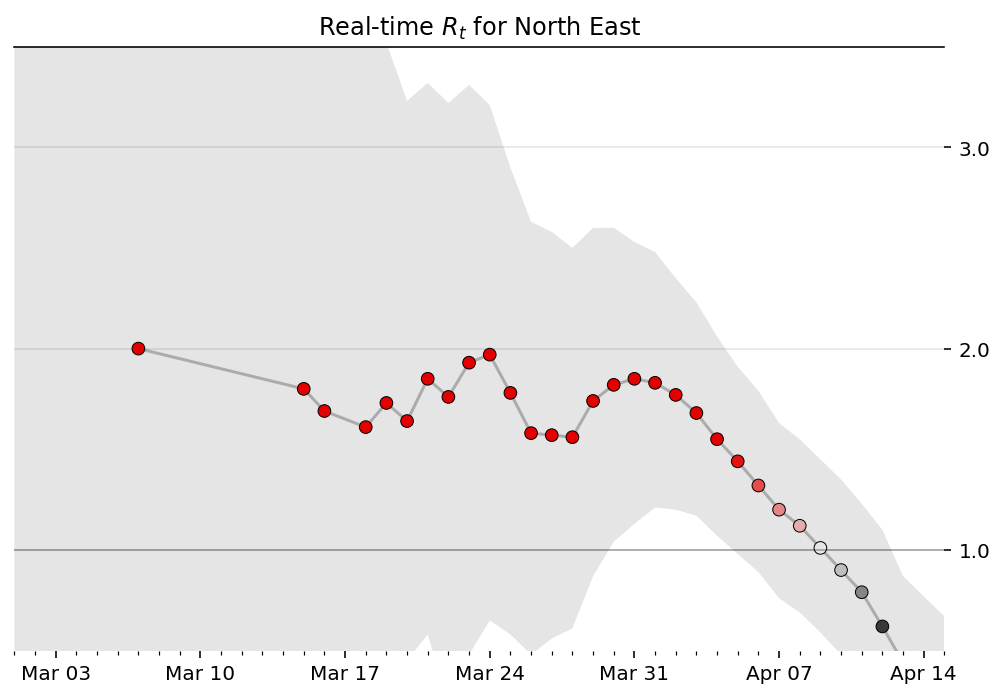

In [65]:
def plot_rt(result, ax, area_name):

    ax.set_title(f"{area_name}")

    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5

    index = result['ML'].index.get_level_values('Specimen date')
    values = result['ML'].values

    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)

    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')

    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')

    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))

    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25)

    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('Specimen date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, area_name)
ax.set_title(f'Real-time $R_t$ for {area_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [66]:
results = {}

regions_to_process = data.loc[data.index.get_level_values('Area name').isin(NORTHEAST_REGIONS)]

for region_name, cases in regions_to_process.groupby(level='Area name'):
    clear_output(wait=True)
    print(f'Processing {region_name}')
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[region_name] = result.droplevel(0)

clear_output(wait=True)
print('Done.')

Done.


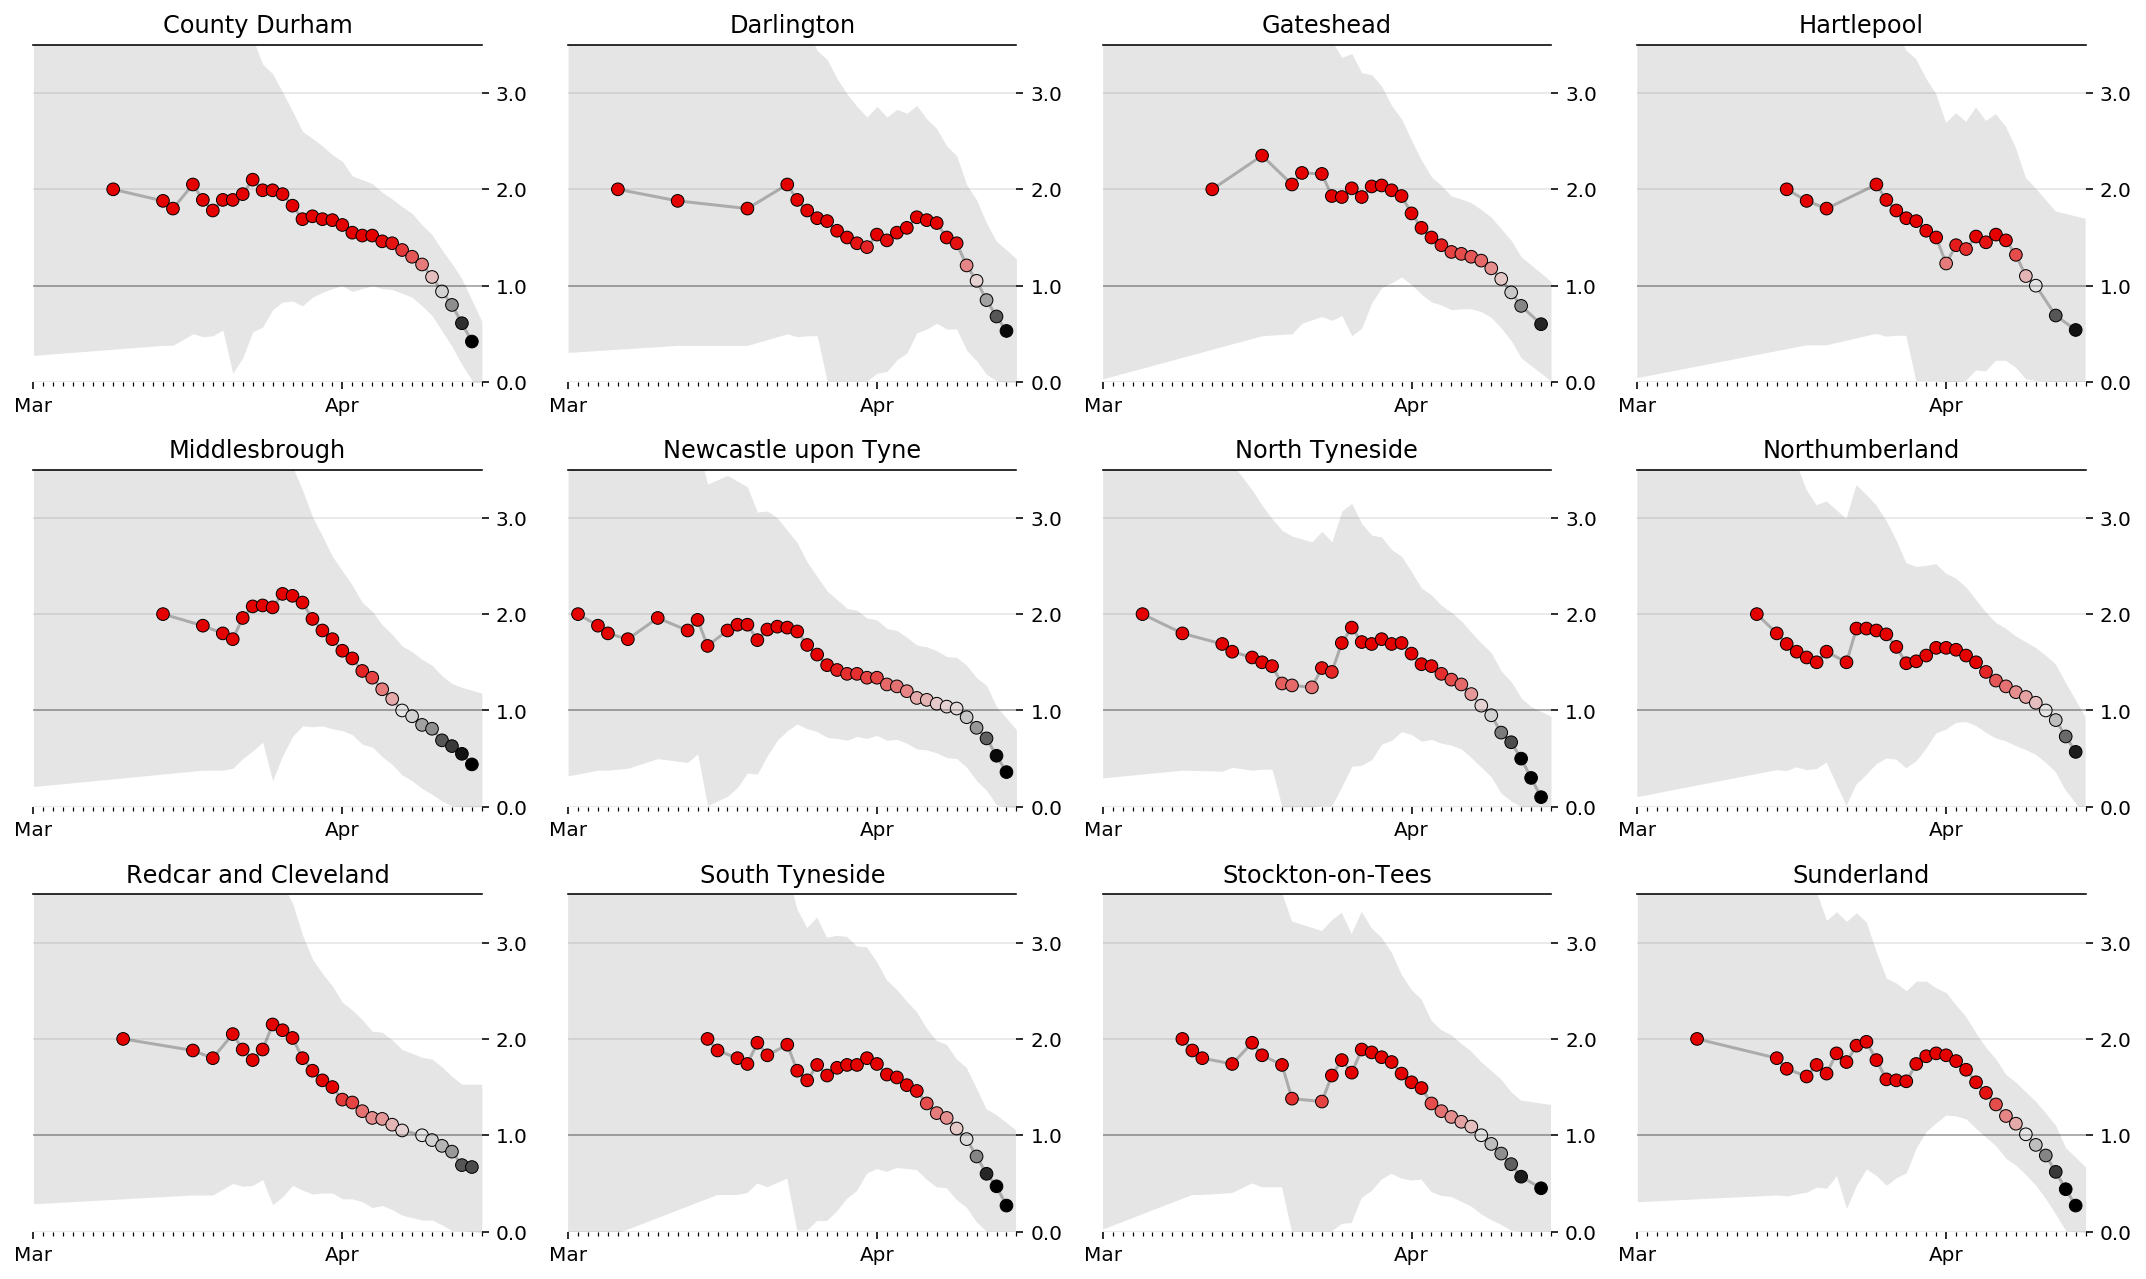

In [67]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (region_name, result) in enumerate(results.items()):
    plot_rt(result, axes.flat[i], region_name)

fig.tight_layout()
fig.set_facecolor('w')

In [78]:
overall = None

for state_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[state_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)

In [79]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]


(<Figure size 281.952x180 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a220ad710>)

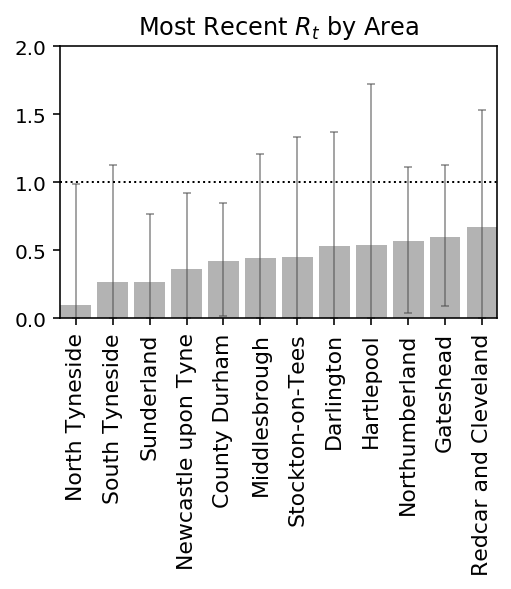

In [80]:
filtered = overall.index.get_level_values(0).isin(NORTHEAST_REGIONS)
mr = overall.loc[filtered].groupby(level=0)[['ML', 'High', 'Low']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Area'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)

    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr)

(<Figure size 281.952x180 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a21e63710>)

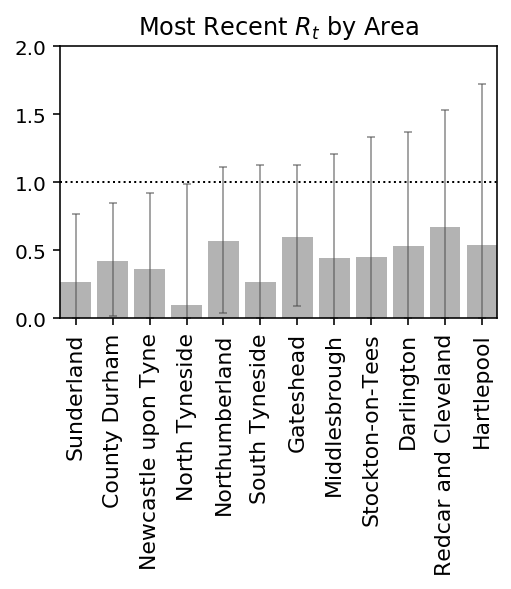

In [81]:
mr.sort_values('High', inplace=True)
plot_standings(mr)

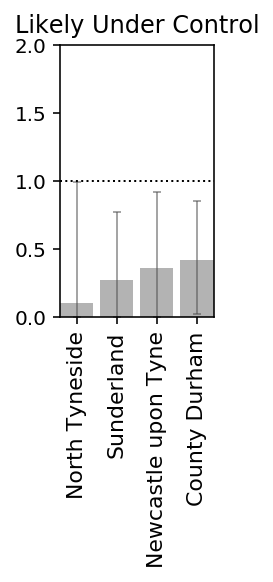

In [82]:
show = mr[mr.High.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control')

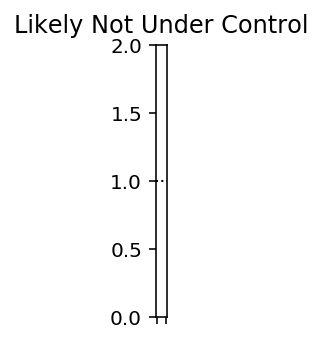

In [84]:
show = mr[mr.Low.ge(1.05)].sort_values('Low')
fig, ax = plot_standings(show, title='Likely Not Under Control')

